In [48]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
%store -r path_figure
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt
logging.getLogger().setLevel(logging.WARNING)

all_analysis_folders = get_analysis_folders()

plate_select = [792,1014,1042,127,130,1023,1045,1053,1048,52,84,938,1076,94,152,102,76,3,12,16,480,91,799,800] #C2
# plates = ['1014_20220525', '1023_20220502', '102_20201226', '1042_20220523',
#        '1045_20220504', '1048_20220506', '1053_20220413', '1076_20220511',
#        '127_20220705', '130_20220707', '152_20201224',"3_20220426", "12_20220502","16_20220419","480_20221205", '52_20220707', '76_20210108',
#        '792_20210915', '799_20211001', '800_20210928', '84_20220621', '91_20220708', '938_20220325', '94_20201123']
plates = ['1042_20220523',
       '1045_20220504', '1048_20220506', '1053_20220413'
         ]
# plates += [
# "850_20230511",
# "840_20230404",
# "861_20230411"
# ]
plates += ["527_20230106","537_20230111"]
plates += ["462_20221013"]
plates += ["532_20220104"]
plates += ["28_20230227",
"206_20230303",
"202_20230314",
"218_20230227",
"219_20230307",
"229_20230330",]
plates += ["510_20221201","521_20230104","530_20230115"]
plates += ["771_20230411","772_20230317"]
plates += [
    "896_20230424",
    "894_20230516",
    "891_20230519",
    "886_20230516",
    "870_20230427",
    "868_20230504",
    "796_20230419",
    "795_20230403",
    "764_20221219",
]
plates += [
        "559_20230109", 
          "544_20230109",
          "531_20221222",
]
plates += [
         "514_20221206",
         "513_20221205",
         "506_20221124",
         "472_20221003"
          ]
plates += [
          "558_20230109",
          "552_20230111",
          "551_20220102",
          "540_20221227",
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
timestep = {32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 65,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:150,152:35,792:60,1048:60,1045:50,941:50}
timestep2 = {102:25,83:70,76:20,81:70,32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 75,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:100,152:35,792:50,1048:60,1045:50}
timestep = {**timestep, **timestep2}
timestep2 = {1014 : 80,1024:25,1027:18,1028:60,1030 : 60,1032 : 50,1042 : 120,1048:70,127:120,129:60,130:50,991:40}
timestep = {**timestep, **timestep2}
timestep2 = {1023 : 60,1031:30,1035:30,1037 : 80,1039 : 90,1045:70,1047:50,1053:40}
timestep = {**timestep, **timestep2}    

timestep2 = {1071 : 25,1076:70,839:60,938 : 35}
timestep = {**timestep, **timestep2}
timestep2 = {30 : 62,32 : 160,33:80}
timestep = {**timestep, **timestep2}
timestep2 = {799 : 100,800 : 25,91:100,99:40}
timestep = {**timestep, **timestep2}
timestep2 = {3:144,16 : 39, 12:70,480:150,28 : 100}
timestep = {**timestep, **timestep2}
timestep2 = {3:144,16 : 39, 12:70,480:150,28 : 100,206 : 90,202 : 100,218 : 100,219 :100,229 :100}
timestep = {**timestep, **timestep2}
for j in range(0,len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    if not plate in timestep.keys():
        timestep[plate] = 100

In [50]:
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,False)
folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders,False)
folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders,False)

In [51]:
time_hypha_info['unique_hypha']=time_hypha_info["end"].astype(int).astype(str)+"_"+time_hypha_info["unique_id"].astype(str)
global_hypha_info['unique_hypha'] = global_hypha_info["index"].astype(int).astype(str)+"_"+global_hypha_info["unique_id"].astype(str)

In [52]:
min_num_occ = 30
max_speeds = time_hypha_info.groupby("unique_hypha").max()["speed"]
correct_tracks = max_speeds.loc[max_speeds <= 450]
select = time_hypha_info.loc[time_hypha_info["unique_hypha"].isin(correct_tracks.index)]
select = select.loc[select["distance_final_pos"] >= 400]
select = select.loc[select["speed"].between(80, 400)]
select = select.loc[select["in_ROI"] == "True"]
num_occ = select.groupby("unique_hypha").count()["speed"]
correct_tracks = num_occ.loc[num_occ >= min_num_occ]
select = select.loc[select["unique_hypha"].isin(correct_tracks.index)]
len(select["unique_hypha"].unique())

345

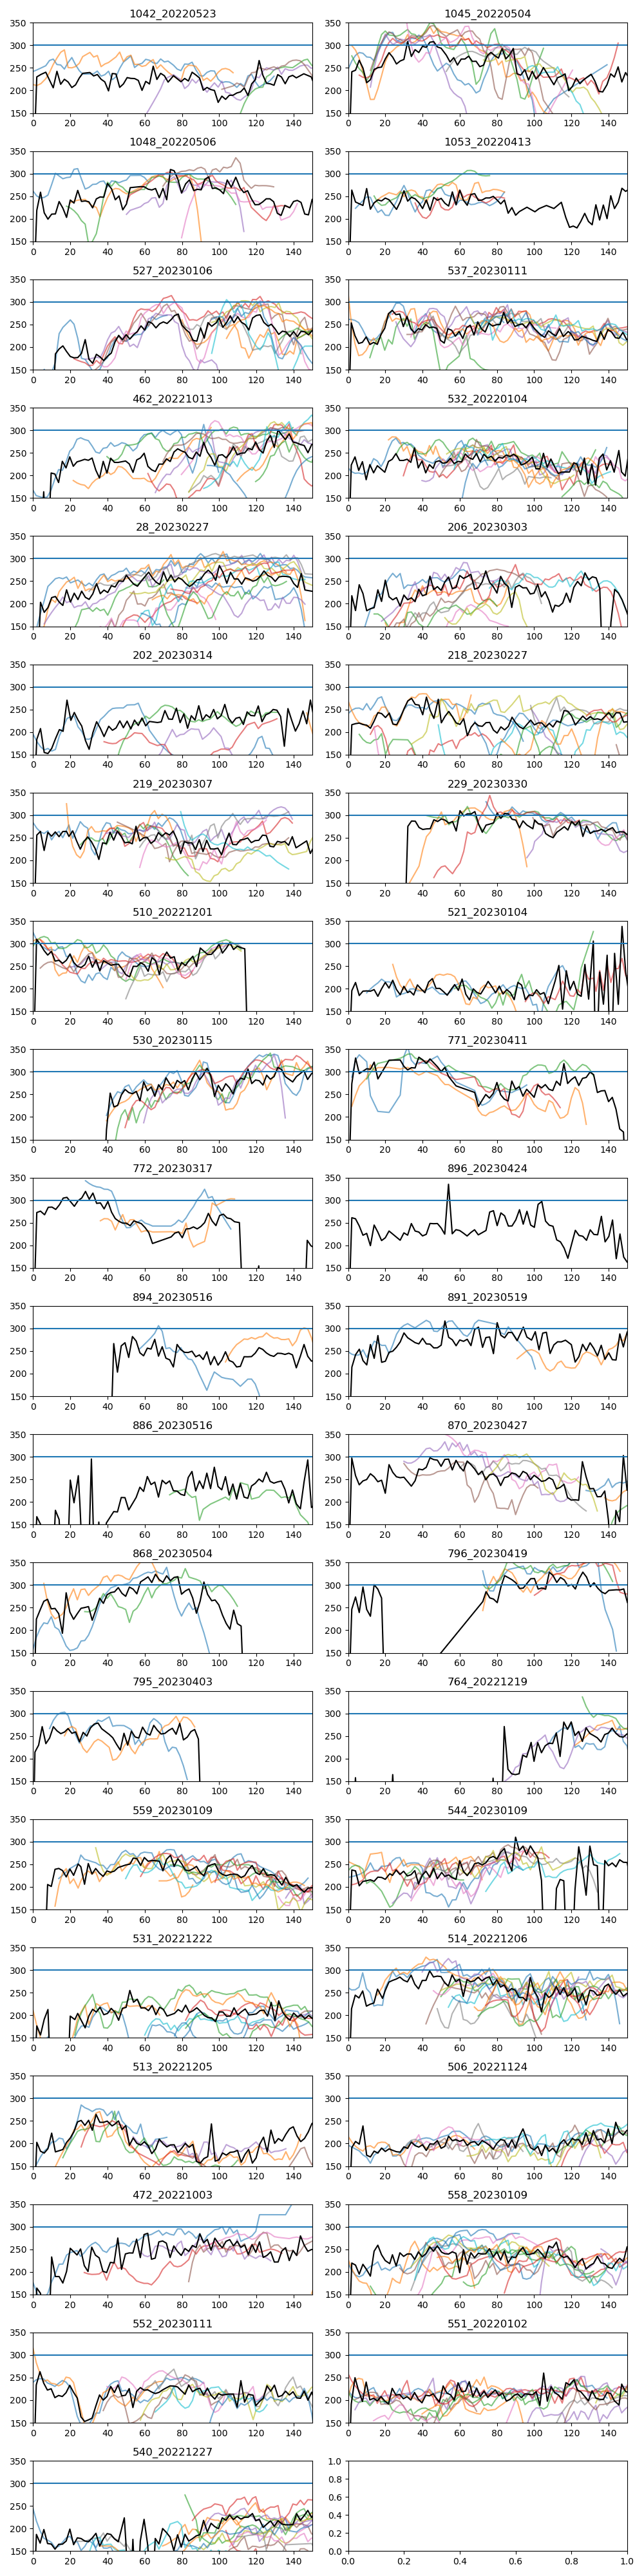

In [53]:
from scipy.signal import savgol_filter
ncols = 2

fig,axs = gridplot(len(plates),ncols = ncols,subh = 2,subw = 5)

ax_list = list(axs)


for k,plate in enumerate(plates):

    ax = ax_list[k]
    select_plate = select[select['unique_id']==int(plate)]
    for hyph in select_plate['unique_hypha'].unique():
        select_hyph = select[select['unique_hypha']==hyph]
        select_hyph = select_hyph[select_hyph['timestep']<=timestep[int(plate.split('_')[0])]]

        select_hyph = select_hyph.sort_values('time_since_emergence')
        time_data = select_hyph['time_since_begin_exp']
        speed_data = select_hyph['speed']
        # Apply Savitzky-Golay smoothing to the speed data
        if len(speed_data) >=9:
            smoothed_speed = savgol_filter(speed_data, window_length=7, polyorder=2)            
            ax.plot(time_data, smoothed_speed,alpha = 0.6)
    select_plate_time = time_plate_info[time_plate_info['unique_id']==int(plate)]
    ax.plot(select_plate_time['time_since_begin_h'],select_plate_time['hull_speed'],color="black")
    ax.set_title(plate)
        
    ax.set_ylim(150,350)
    ax.hlines(300,0,150)
    ax.set_xlim(0,150)
    # break
plt.tight_layout()

C:\Users\coren\AppData\Local\Temp\ipykernel_1616\2283320307.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


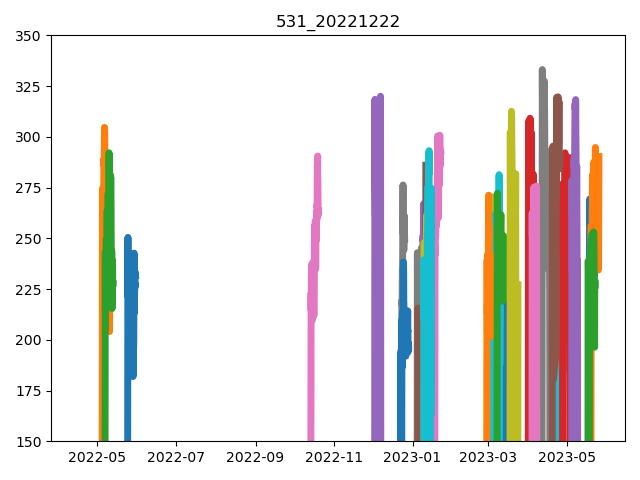

In [38]:
from scipy.signal import savgol_filter
ncols = 2

fig,ax = plt.subplots()



for k,plate in enumerate(plates):

    select_plate = select[select['unique_id']==int(plate)]
#     for hyph in select_plate['unique_hypha'].unique():
#         select_hyph = select[select['unique_hypha']==hyph]
#         select_hyph = select_hyph[select_hyph['timestep']<=timestep[int(plate.split('_')[0])]]

#         select_hyph = select_hyph.sort_values('time_since_emergence')
#         time_data = select_hyph['datetime']
#         speed_data = select_hyph['speed']
#         # Apply Savitzky-Golay smoothing to the speed data
    select_plate_time = time_plate_info[time_plate_info['unique_id']==int(plate)]
    select_plate_time = select_plate_time[select_plate_time['time_since_begin_h']<=150]
    
    
    speed_data = select_plate_time['hull_speed'].fillna(0)
    if len(speed_data) >=9:
        smoothed_speed = savgol_filter(speed_data, window_length=7, polyorder=2)            
    x = pd.to_datetime(select_plate_time['date'], format='%d.%m.%Y, %H:%M:')
    ax.plot(x,smoothed_speed,linewidth = 5)
    ax.set_title(plate)
        
    ax.set_ylim(150,350)
    # ax.hlines(300,0,150)
    # ax.set_xlim(0,150)
    # break
plt.tight_layout()

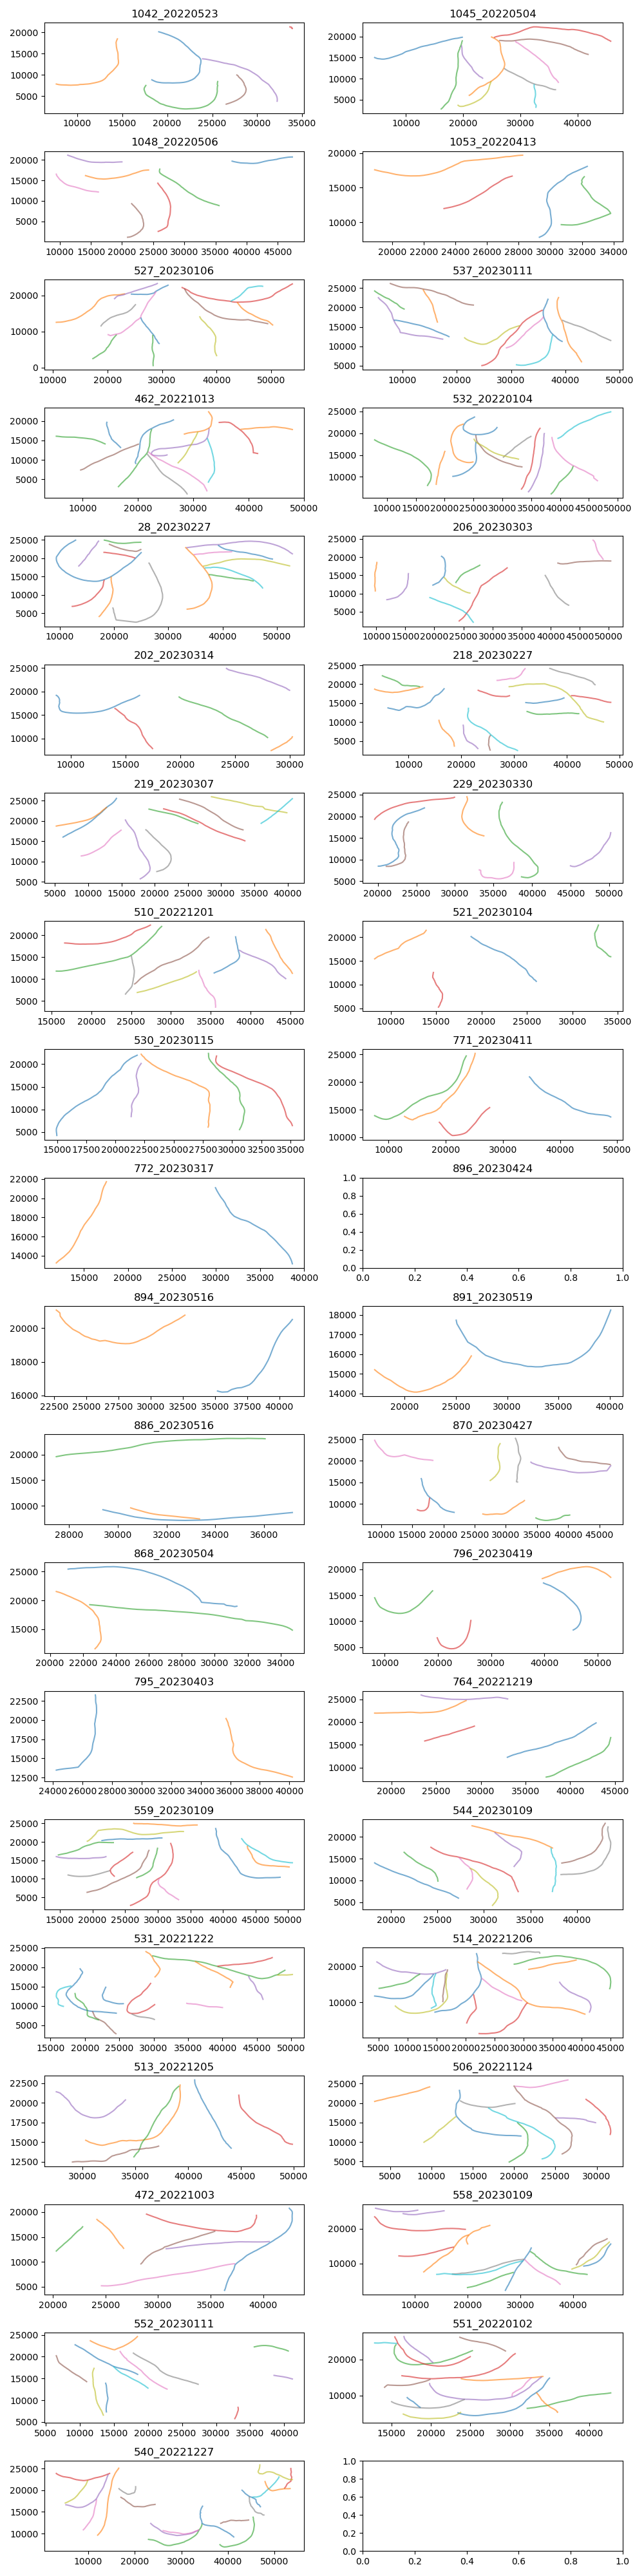

In [54]:
from scipy.signal import savgol_filter
ncols = 2

fig,axs = gridplot(len(plates),ncols = ncols,subh = 2,subw = 5)

ax_list = list(axs)
time_datas_plate = {}
speed_datas_plate = {}
speed_datas_plate_smooth = {}
xpos_datas_plate = {}
ypos_datas_plate = {}

for k,plate in enumerate(plates):
    time_datas = []
    speed_datas = []
    smooth_speed_datas = []
    xpos_datas = []
    ypos_datas = []
    ax = ax_list[k]
    select_plate = select[select['unique_id']==int(plate)]
    for hyph in select_plate['unique_hypha'].unique():
        select_hyph = select[select['unique_hypha']==hyph]
        select_hyph = select_hyph[select_hyph['timestep']<=timestep[int(plate.split('_')[0])]]

        select_hyph = select_hyph.sort_values('time_since_emergence')
        time_data = select_hyph['time_since_begin_exp']
        speed_data = select_hyph['speed']
        xpos_data = select_hyph['pos_x']
        ypos_data = select_hyph['pos_y']
        time_datas.append(time_data.values)
        speed_datas.append(speed_data.values)
        xpos_datas.append(xpos_data)
        ypos_datas.append(ypos_data)
        # Apply Savitzky-Golay smoothing to the speed data
        if len(speed_data) >=9:
            smoothed_speed = savgol_filter(speed_data, window_length=7, polyorder=2)
            smooth_speed_datas.append(smoothed_speed)
            
            # ax.plot(time_data, smoothed_speed,alpha = 0.6)
            ax.plot(ypos_data.values, xpos_data.values,alpha = 0.6)
            
        else:
            smooth_speed_datas.append(speed_data)     
    # ax.set_ylim(150,350)
    time_datas_plate[plate] = time_datas
    speed_datas_plate[plate] = speed_datas
    speed_datas_plate_smooth[plate] = smooth_speed_datas
    xpos_datas_plate[plate] = xpos_datas
    ypos_datas_plate[plate] = ypos_datas
    ax.set_title(plate)
plt.tight_layout()
    
    
    # break
    

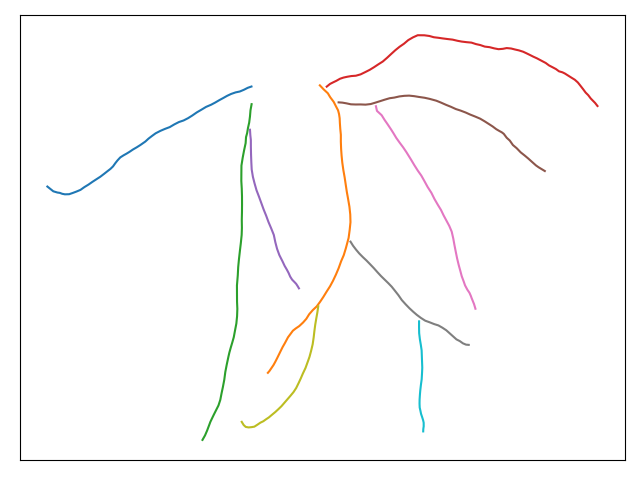

In [67]:
from scipy.signal import savgol_filter
ncols = 2

fig,ax = plt.subplots()

time_datas_plate = {}
speed_datas_plate = {}
speed_datas_plate_smooth = {}
xpos_datas_plate = {}
ypos_datas_plate = {}

for k,plate in enumerate(plates[1:2]):
    time_datas = []
    speed_datas = []
    smooth_speed_datas = []
    xpos_datas = []
    ypos_datas = []
    select_plate = select[select['unique_id']==int(plate)]
    for hyph in select_plate['unique_hypha'].unique():
        select_hyph = select[select['unique_hypha']==hyph]
        select_hyph = select_hyph[select_hyph['timestep']<=timestep[int(plate.split('_')[0])]]

        select_hyph = select_hyph.sort_values('time_since_emergence')
        time_data = select_hyph['time_since_begin_exp']
        speed_data = select_hyph['speed']
        xpos_data = select_hyph['pos_x']
        ypos_data = select_hyph['pos_y']
        time_datas.append(time_data.values)
        speed_datas.append(speed_data.values)
        xpos_datas.append(xpos_data)
        ypos_datas.append(ypos_data)
        # Apply Savitzky-Golay smoothing to the speed data
        if len(speed_data) >=9:
            smoothed_speed = savgol_filter(speed_data, window_length=7, polyorder=2)
            smooth_speed_datas.append(smoothed_speed)
            
            # ax.plot(time_data, smoothed_speed,alpha = 0.6)
            ax.plot(ypos_data.values, xpos_data.values,alpha = 1)
            
        else:
            smooth_speed_datas.append(speed_data)     
    # ax.set_ylim(150,350)
    time_datas_plate[plate] = time_datas
    speed_datas_plate[plate] = speed_datas
    speed_datas_plate_smooth[plate] = smooth_speed_datas
    xpos_datas_plate[plate] = xpos_datas
    ypos_datas_plate[plate] = ypos_datas
    # ax.set_title(plate)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()

    
    # break
    

In [55]:
def generate_all_pairs(input_list):
    all_pairs = []
    for i in range(len(input_list)):
        for j in range(i+1, len(input_list)):
            pair = (input_list[i], input_list[j])
            all_pairs.append(pair)
    return all_pairs

In [56]:
import random
def get_cross_cor(xs,ys,shuffle=False):
    min_time = max(min(time_points) for time_points in xs)
    max_time = min(max(time_points) for time_points in xs)
    if min_time<max_time:
        # Interpolate or resample signals within the common time range
        common_time_grid = np.linspace(min_time, max_time, num=100)  # Adjust num as needed
        resampled_speed_data = []

        for i in range(len(xs)):
            resampled_speed = np.interp(common_time_grid, xs[i], ys[i])
            if shuffle:
                random.shuffle(resampled_speed)
            resampled_speed_data.append((resampled_speed-np.mean(resampled_speed))/np.std(resampled_speed))
        # Compute cross-correlation between the resampled signals
        cross_correlations = []
        correlation = correlate(resampled_speed_data[1], resampled_speed_data[0], mode='same')
        range_time = max_time-min_time
        time_lags = np.linspace(-range_time/2, range_time/2, len(correlation))
        return(time_lags,correlation/len(correlation))
    else:
        return([],[])

In [57]:
def resample_common(xpos,ypos,xs):
    min_time = max(min(time_points) for time_points in xs)
    max_time = min(max(time_points) for time_points in xs)
    if min_time<max_time:
        # Interpolate or resample signals within the common time range
        common_time_grid = np.linspace(min_time, max_time, num=100)  # Adjust num as needed
        resampled_xpos_data = []
        resampled_ypos_data = []
        for i in range(len(xs)):
            resampled_xpos = np.interp(common_time_grid, xs[i], xpos[i])
            resampled_xpos_data.append(resampled_xpos)
            resampled_ypos = np.interp(common_time_grid, xs[i], ypos[i])
            resampled_ypos_data.append(resampled_ypos)
        return(resampled_xpos_data,resampled_ypos_data)
    else:
        return([],[])

In [58]:
def find_peak_correlation(time_lags, correlation):
    peak_index = np.argmax(np.abs(correlation))
    peak_time_lag = time_lags[peak_index]
    peak_value = correlation[peak_index]
    return peak_time_lag, peak_value

In [59]:
result_data = []

for plate in plates:
    # fig,ax = plt.subplots()

    time_datas, smooth_speed_datas = time_datas_plate[plate], speed_datas_plate_smooth[plate]
    x_datas,y_datas = xpos_datas_plate[plate],ypos_datas_plate[plate]
    pair_time_datas = generate_all_pairs(time_datas)
    pair_speed_datas = generate_all_pairs(smooth_speed_datas)
    pair_x_datas =generate_all_pairs(x_datas)
    pair_y_datas =generate_all_pairs(y_datas)
    for i in range(len(pair_time_datas)):
        xs = pair_time_datas[i]
        ys = pair_speed_datas[i]
        xpos = pair_x_datas[i]
        ypos = pair_y_datas[i]
        if len(xs[0]) > 0 and len(xs[1]) > 0:
            time_lags, correlation = get_cross_cor(xs, ys)
            resampled_xpos_pair,resampled_ypos_pair = resample_common(xpos,ypos,xs)
            if len(time_lags)>10:
                dist = (resampled_xpos_pair[0]-resampled_xpos_pair[1])**2
                dist += (resampled_ypos_pair[0]-resampled_ypos_pair[1])**2
                mean_dist = np.mean(np.sqrt(dist))
                init_dist = np.sqrt(dist)[0]
                
                peak_time_lag, peak_value = find_peak_correlation(time_lags, correlation)
                result_data.append({
                    'plate': plate,
                    'peak_value': peak_value,
                    'peak_time_lag': peak_time_lag,
                    'mean_dist': mean_dist,
                    'init_dist': init_dist,
                    'shuffled' : False
                })
#                 time_lags, correlation = get_cross_cor(xs, ys,shuffle=True)

#                 peak_time_lag, peak_value = find_peak_correlation(time_lags, correlation)
#                 result_data.append({
#                     'plate': plate,
#                     'peak_value': peak_value,
#                     'peak_time_lag': peak_time_lag,
#                     'mean_dist': mean_dist,
#                     'init_dist': init_dist,
#                     'shuffled' : True


#                 })
                # Plotting (you can keep this part)
                # ax.plot(time_lags,correlation,alpha = 0.2,color="grey")
                

# Create a pandas DataFrame
df = pd.DataFrame(result_data)

In [60]:
num_bins = 5  # Choose the number of bins you want
df['init_dist_bin'] = pd.cut(df['init_dist'], bins=num_bins)
df['abs_peak_time_lag'] = np.abs(df['peak_time_lag'])

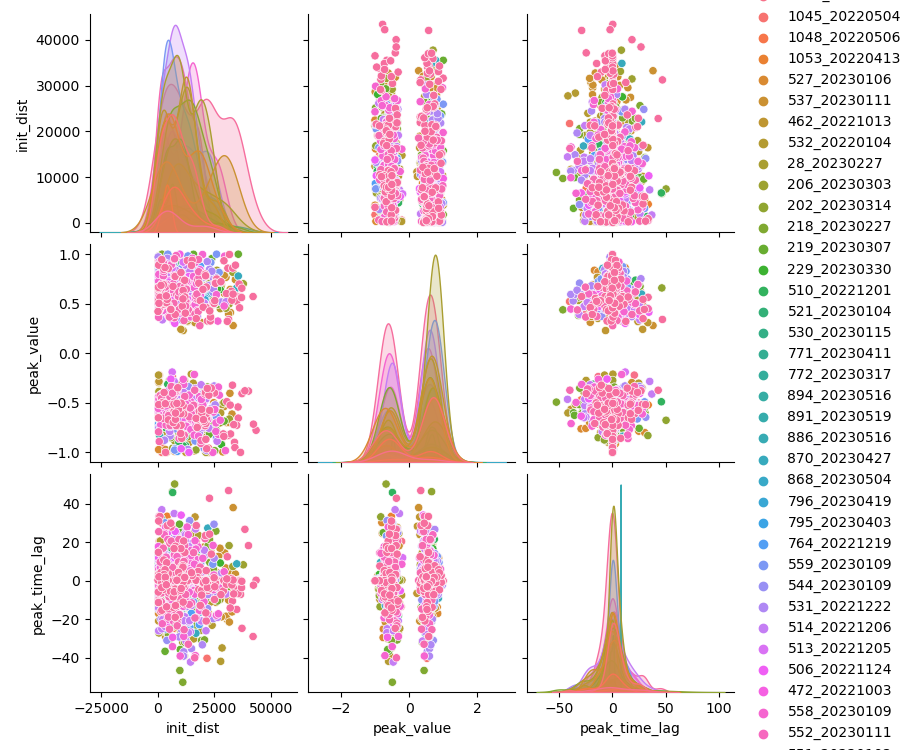

In [61]:
import seaborn as sns
sns.pairplot(df,hue="plate",diag_kind = "kde",vars = ["init_dist","peak_value","peak_time_lag"])

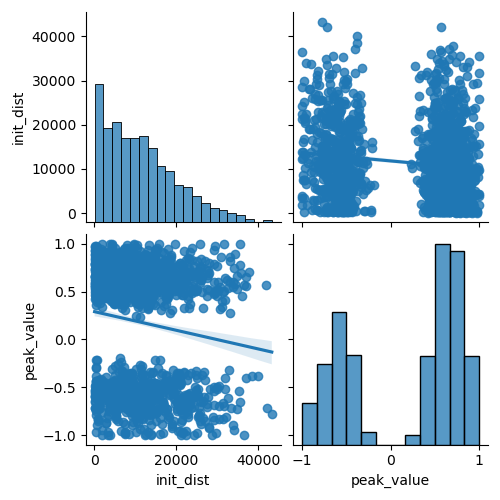

In [62]:
sns.pairplot(df,kind = "reg",vars = ["init_dist","peak_value"])

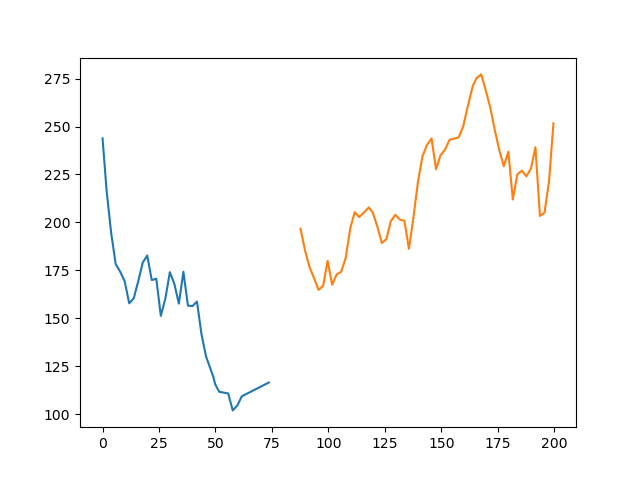

In [63]:
i = 1
xs = pair_time_datas[i]
ys = pair_speed_datas[i]
fig,ax = plt.subplots()
ax.plot(xs[0],ys[0])
ax.plot(xs[1],ys[1])

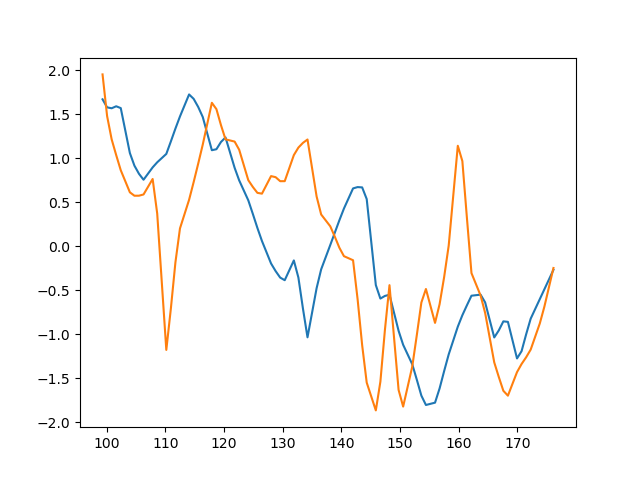

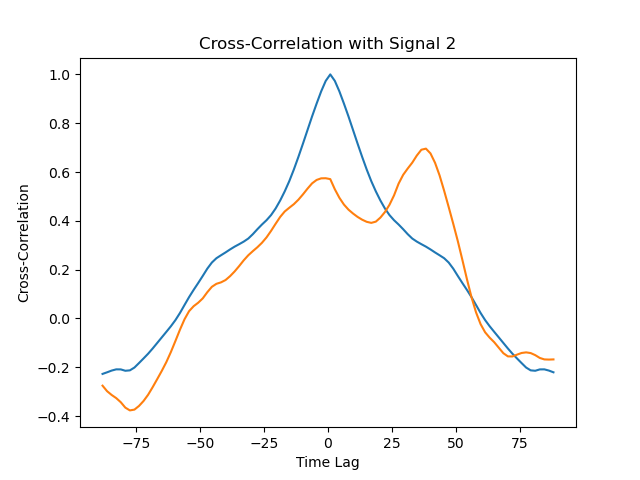

In [30]:


# Determine the overall minimum and maximum timepoints
min_time = max(min(time_points) for time_points in xs)
max_time = min(max(time_points) for time_points in xs)

# Interpolate or resample signals within the common time range
common_time_grid = np.linspace(min_time, max_time, num=100)  # Adjust num as needed
resampled_speed_data = []
fig, ax = plt.subplots()

for i in range(len(xs)):
    resampled_speed = np.interp(common_time_grid, xs[i], ys[i])
    resampled_speed_data.append((resampled_speed-np.mean(resampled_speed))/np.std(resampled_speed))
    ax.plot(common_time_grid,(resampled_speed-np.mean(resampled_speed))/np.std(resampled_speed))
# Compute cross-correlation between the resampled signals
cross_correlations = []
for i in range(len(resampled_speed_data)):
    correlation = correlate(resampled_speed_data[i], resampled_speed_data[0], mode='same')
    cross_correlations.append(correlation)

# Plot cross-correlations
fig, ax = plt.subplots()

for i, correlation in enumerate(cross_correlations):
    time_lags = np.linspace(-max_time/2, max_time/2, len(correlation))
    ax.plot(time_lags, correlation/len(correlation))
    ax.set_xlabel('Time Lag')
    ax.set_ylabel('Cross-Correlation')
    ax.set_title(f'Cross-Correlation with Signal {i + 1}')

